In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import networkx as nx
from collections import Counter
import math
from mpl_toolkits.mplot3d import Axes3D

# Define a class for Bison with attributes and voting behavior
class Bison:
    """
    Defines a Bison with characteristics: a position on a 2D plane, 
    an initial vote and a final decision ( = assertion of where the herd is going as a whole)
    bisons also have a name used only to track them in code
    """ 
    def __init__(self, name, x_position, y_position, abstention_rate, voting_bias):
        """
        Given a location, generates a bison with a random (uniform) voting status: vote A, vote B, no vote
        the likelihood of which can be parametrized through 'abstention_rate' and 'voting_bias'
        """
        self.name = name
        self.x = x_position
        self.y = y_position
        self.position = [x_position, y_position]

        # Determine voting behavior based on abstention rate and voting bias
        a = np.random.uniform(0, 1)
        if a < abstention_rate / 100:
            self.vote = 0  # Abstains from voting
        else:
            b = np.random.uniform(0, 1)
            self.vote = 1 if b > voting_bias / 100 else -1  # Vote A or B

# Function to generate a single Bison with a unique position
def generate_herd(plane_length, herd_positions, abstention_rate, voting_bias):
    """
    Generates and places a bison with a given vote (based on abstention_rate, voting_bias)
    Position is generated randomly (uniform) in a circle of radius 'plane_length / 2'
    Recorded in the list 'herd_positions' to ensure uniqueness
    """
    while True:
        # Generate a random position within a circular area
        radius = np.sqrt(np.random.uniform(0, 1)) * plane_length / 2
        theta = np.random.uniform(0, 2 * np.pi)
        x = radius * np.cos(theta) + plane_length
        y = radius * np.sin(theta) + plane_length
        new_position = [x, y]

        # Ensure the position is unique
        if new_position not in herd_positions:
            herd_positions.append(new_position)
            name = len(herd_positions) - 1
            return Bison(name, x, y, abstention_rate, voting_bias)

# Function to simulate the behavior of a herd of Bisons
def simulate_herd(vision_range, herd_size, abstention_rate, voting_bias, plane_length=100):
    """
    Creates a network where bisons (nodes) are connected if within 'vision_range' distance.
    Assigns final 'decision' based on neighbor votes: A, B, or undecided.
    Measures success by how well herd's final decision aligns with initial votes.
    """
    herd = []  # List to store all Bison objects
    herd_positions = []  # List to store their positions

    # Generate the herd with unique positions
    for i in range(herd_size):
        herd.append(generate_herd(plane_length, herd_positions, abstention_rate, voting_bias))

    # Create a k-d tree for efficient neighbor searching
    tree = cKDTree(herd_positions)
    neighbours = tree.query_pairs(vision_range)
    paired_bisons = list(neighbours)

    # Create a network graph
    network_bisons = nx.Graph()
    network_bisons.add_nodes_from(range(len(herd)))
    network_bisons.add_edges_from(neighbours)

    # Identify the largest connected component
    largest_cc = max(nx.connected_components(network_bisons), key=len)
    largest_cc_size = len(largest_cc)
    cc_ratio = largest_cc_size / herd_size * 100

    # Compute the average number of neighbors
    average_connection_size = sum(dict(network_bisons.degree()).values()) / len(network_bisons)

    # Categorize Bisons based on their initial votes
    no_vote = [bis for bis in herd if bis.vote == 0]
    vote_a = [bis for bis in herd if bis.vote == 1]
    vote_b = [bis for bis in herd if bis.vote == -1]

    # Initialize decisions with the original vote
    for bis in herd:
        bis.decision = bis.vote

    # Update decisions based on neighbor votes
    for pair in paired_bisons:
        bis_a = next(bis for bis in herd if bis.name == pair[0])
        bis_b = next(bis for bis in herd if bis.name == pair[1])
        bis_a.decision += bis_b.vote
        bis_b.decision += bis_a.vote

    # Normalize decisions to -1, 0, or 1
    for bis in herd:
        bis.decision = np.sign(bis.decision)

    # Determine majority vote
    initial_votes = [bis.vote for bis in herd]
    majority_initial_vote = np.sum(initial_votes)
    decisions = [bis.decision for bis in herd]
    majority_decision = np.sum(decisions)
    winner = np.sign(majority_decision)

    # Count final decisions
    vote_counts = Counter(bis.decision for bis in herd)

    # Determine success metrics
    if np.sign(majority_initial_vote) != np.sign(majority_decision) or \
            np.sign(majority_initial_vote) == 0 or np.sign(majority_decision) == 0:
        success_count = 0
        success_rate = 0
    else:
        success_count = 1
        tally = [x for x in herd if x.decision == winner]
        success_rate = len(tally) * 100 / herd_size

    # Return results
    return herd, paired_bisons, no_vote, vote_a, vote_b, cc_ratio, \
        largest_cc_size, success_rate, success_count, average_connection_size, decisions

In [21]:
def results(herd, no_vote, vote_a, vote_b, paired_bisons, cc_ratio, largest_cc_size, plane_length=100):
    """
    Plots the following:
    - A generated herd with votes and decision color-coded (separately)
    - A network graph of the connected bison in said herd

    Also prints the tally of votes and decisions.
    """
    # Define color mapping and labels for bison votes and decisions
    color_map = {0: 'grey', 1: 'blue', -1: 'red'}
    voting_record = {0: 'No vote', 1: 'Vote A', -1: 'Vote B'}
    voting_record_2 = {0: 'Undecided', 1: 'Going A', -1: 'Going B'}
    
    # Plot the herd with initial votes
    fig, ax = plt.subplots(figsize=(8, 7))
    fig.patch.set_facecolor('#D2B48C')  # Background color
    
    for bis in herd:
        ax.scatter(bis.x, bis.y, marker='o', s=30, color=color_map[bis.vote], label=voting_record[bis.vote])
    
    ax.set_xlabel('Plane (X-axis)')
    ax.set_ylabel('Plane (Y-axis)')
    ax.set_xlim(.4 * plane_length, 1.6 * plane_length)
    ax.set_ylim(.4 * plane_length, 1.6 * plane_length)
    ax.set_title('Herd with Assigned Votes')
    
    # Add legend dynamically
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=f'{voting_record[v]}', 
                   markerfacecolor=color, markersize=10)
        for v, color in color_map.items()
    ], title='Legend', loc='upper right')
    
    plt.savefig('run_initial_voting.png', dpi=300)
    plt.show()
    
    # Print initial vote tally
    print(
        f'Tally:\nNo vote : {len(no_vote)}\n'
        f'Direction A : {len(vote_a)}\n'
        f'Direction B : {len(vote_b)}'
    )
    
    # Create a network graph of bison based on neighbor pairs
    network_bisons = nx.Graph()
    network_bisons.add_nodes_from(range(len(herd)))  # Add nodes for all bison
    network_bisons.add_edges_from(paired_bisons)  # Add edges based on neighbors
    
    node_colors = [color_map[bis.vote] for bis in herd]  # Assign colors to nodes
    
    fig, ax = plt.subplots(figsize=(8, 7))
    fig.patch.set_facecolor('#D2B48C')  # Light brown background
    
    nx.draw(network_bisons, with_labels=False, node_color=node_colors, 
            node_size=20, edge_color='black', ax=ax)
    
    ax.set_title('Bison Network (Connected by Sight)')
    plt.show()
    
    # Print statistics on the largest connected component
    print(
        f'The largest connected subgroup is made of {largest_cc_size} bison \n'
        f'{cc_ratio:.0f}% of the herd is connected'
    )
    
    # Plot the herd with final decisions
    fig, ax = plt.subplots(figsize=(8, 7))
    fig.patch.set_facecolor('#D2B48C')
    
    for bis in herd:
        ax.scatter(bis.x, bis.y, marker='o', s=30, color=color_map[bis.decision], label=voting_record_2[bis.decision])
    
    ax.set_xlabel('Plane (X-axis)')
    ax.set_ylabel('Plane (Y-axis)')
    ax.set_xlim(.4 * plane_length, 1.6 * plane_length)
    ax.set_ylim(.4 * plane_length, 1.6 * plane_length)
    ax.set_title("Herd's Decision")
    
    # Add legend dynamically
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=f'{voting_record_2[v]}', 
                   markerfacecolor=color, markersize=10)
        for v, color in color_map.items()
    ], title='Legend', loc='upper right')
    
    plt.savefig('run_final_decision.png', dpi=300)
    plt.show()
    
    # Categorize bison based on their final decision
    undecided = [bis for bis in herd if bis.decision == 0]
    going_a = [bis for bis in herd if bis.decision == 1]
    going_b = [bis for bis in herd if bis.decision == -1]
    
    # Print final decision tally
    print(
        f'New Tally:\nUndecided : {len(undecided)}\n'
        f'Direction A : {len(going_a)}\n'
        f'Direction B : {len(going_b)}'
    )


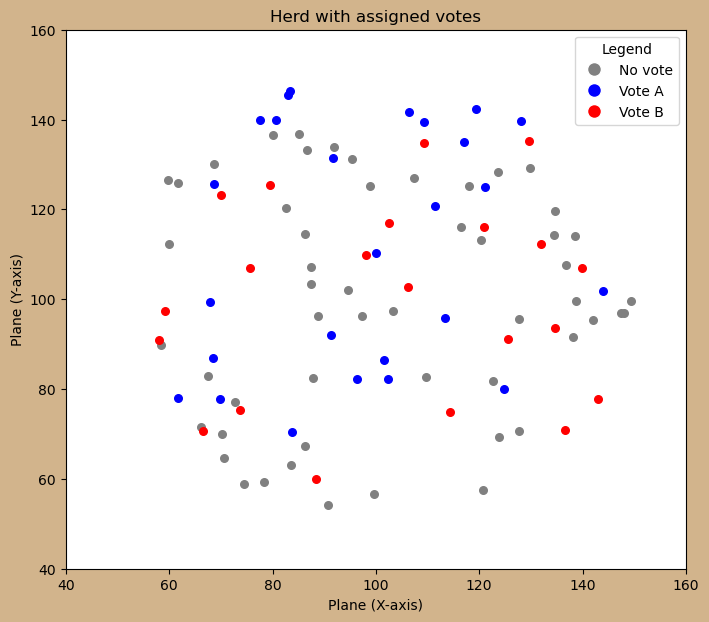

Tally:
No vote : 53
Direction A : 26
Direction B : 21


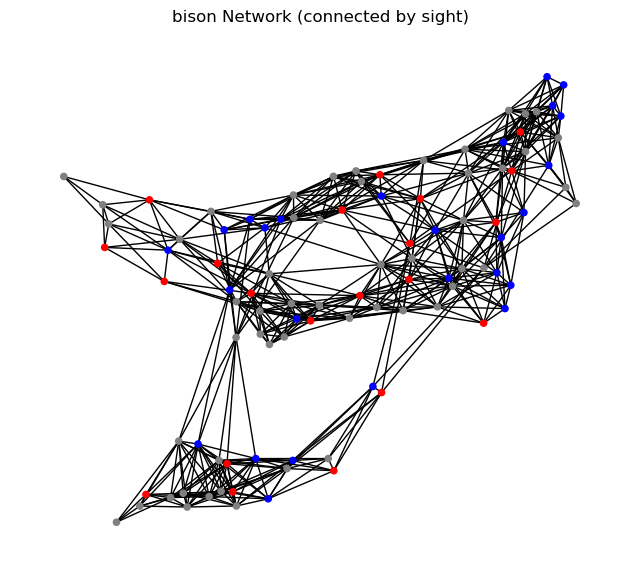

The largest connected subgroup is made of 100 bisons 
100% of the herd is connected


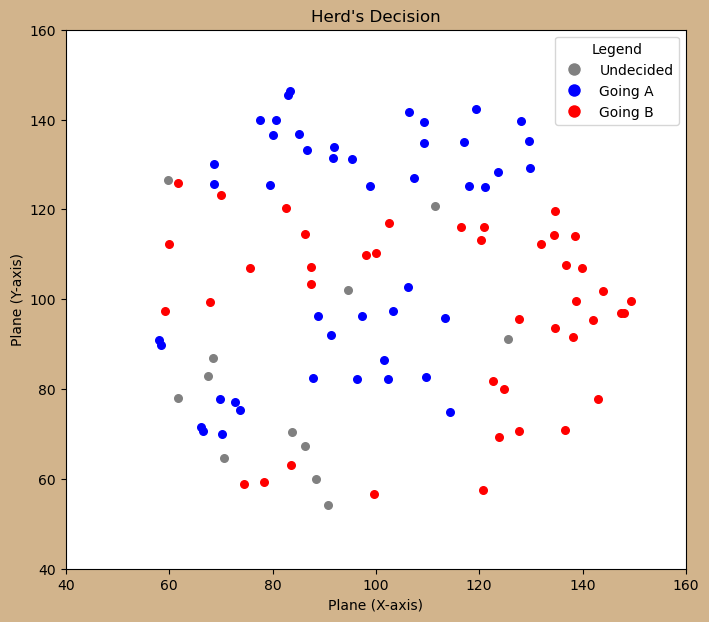

New Tally:
Undecided : 12
Direction A : 46
Direction B : 42
11.7


In [23]:
"""
Test run of the above functions
"""

vision_range = 19
herd_size = 100
abstention_rate = 55
voting_bias = 50
    
herd, paired_bisons, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, success_rate, success_count, \
average_connection_size, decisions = simulate_herd(vision_range, herd_size, abstention_rate, voting_bias)
results(herd, no_vote, vote_a, vote_b, paired_bisons, cc_ratio, largest_cc_size)
print(average_connection_size)

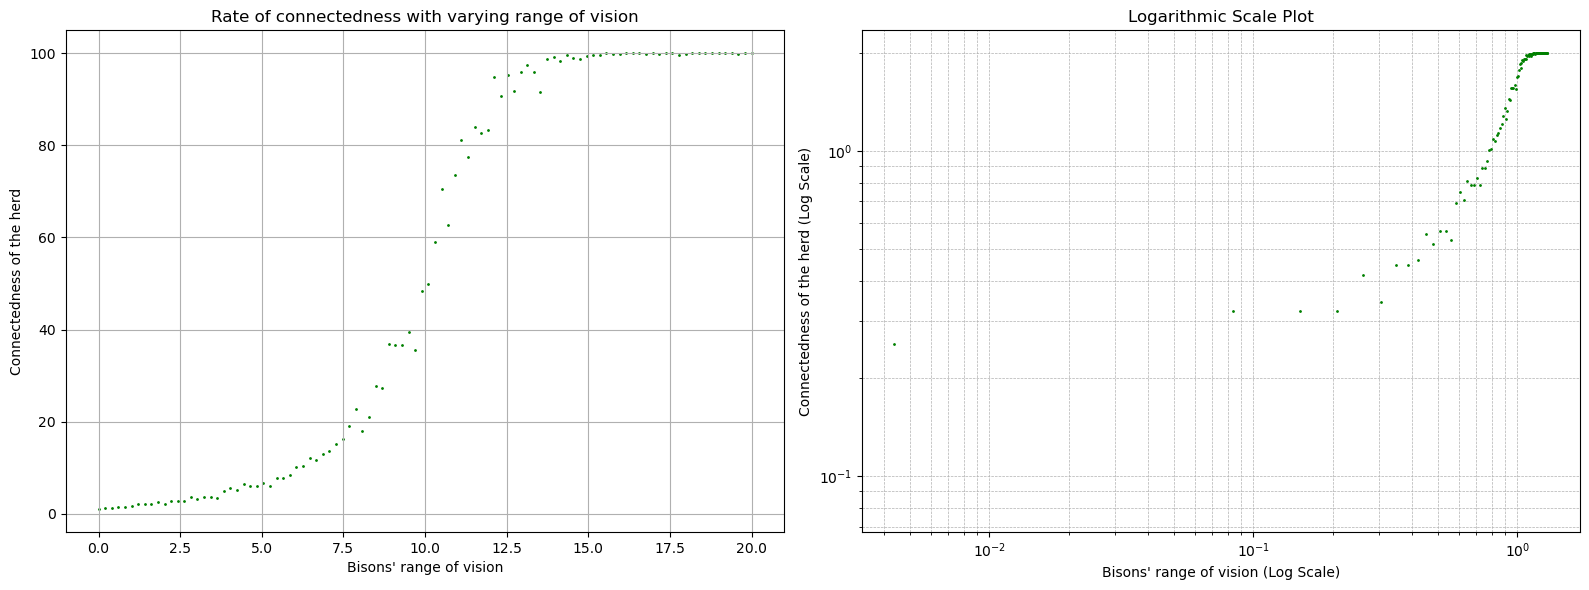

In [27]:
"""
Computing the average size of giant component of the herd network over 10 generated herds with varying vision range
"""

vision_range_r = np.linspace(0, 20, 100)
connectivity = []
abstention_rate = 55
voting_bias = 50

for i in vision_range_r:
    con = []
    for _ in range(10):
        herd, paired_bisons, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, success_rate, success_count, average_connection_size, decisions = simulate_herd(vision_range = i,
        herd_size=100, abstention_rate = abstention_rate, voting_bias = voting_bias)
        con.append(cc_ratio)
    j = np.mean(con)
    connectivity.append(j)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First subplot (scatter plot)
axes[0].scatter(vision_range_r, connectivity, s=1, color='green')
axes[0].set_xlabel("Bisons' range of vision")
axes[0].set_ylabel('Connectedness of the herd')
axes[0].set_title('Rate of connectedness with varying range of vision')
axes[0].grid(True)

# Second subplot (log-log plot)
connectivity_log = [math.log10(x) if x > 0 else 0 for x in connectivity]
vision_range_r_log = [math.log10(x) if x>0 else 0 for x in vision_range_r]

axes[1].loglog(vision_range_r_log, connectivity_log, marker='o', linestyle='', color='green', markersize=1)
axes[1].set_xlabel("Bisons' range of vision (Log Scale)")
axes[1].set_ylabel("Connectedness of the herd (Log Scale)")
axes[1].set_title("Logarithmic Scale Plot")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
#plt.savefig('Connect_range_vision.png', dpi=300)
plt.show()

In [33]:
def bootstrap_ci(data, num_bootstrap_samples=1000, ci=95):
    """
    Perform bootstrapping on multiple experiments and compute confidence intervals.
   
    Parameters:
    - data: 2D numpy array or list of lists, where each row is an experiment.
    - num_bootstrap_samples: Number of bootstrap resamples.
    - ci: Confidence interval percentage (default 95%).
   
    Returns:
    - means: Array of bootstrap means for each experiment.
    - lower_bounds: Lower bound of the confidence interval for each experiment.
    - upper_bounds: Upper bound of the confidence interval for each experiment.
    """

    num_experiments = len(data)  # Number of experiments (rows)
    
    # Initialize arrays to store results
    means = np.zeros(num_experiments)
    lower_bounds = np.zeros(num_experiments)
    upper_bounds = np.zeros(num_experiments)

    for i in range(num_experiments):
        bootstrap_means = np.zeros(num_bootstrap_samples)  # Store means of bootstrap resamples
        
        # Generate bootstrap samples
        for j in range(num_bootstrap_samples):
            sample = np.random.choice(data[i], size=len(data[i]), replace=True)
            bootstrap_means[j] = np.mean(sample)  # Compute mean of resampled data
        
        # Compute statistics
        means[i] = np.mean(bootstrap_means)
        lower_bounds[i] = np.percentile(bootstrap_means, (100 - ci) / 2)  # Lower bound
        upper_bounds[i] = np.percentile(bootstrap_means, 100 - (100 - ci) / 2)  # Upper bound
        
    return means, lower_bounds, upper_bounds


In [45]:
"""
Generate a matrix of data for bootstrapping: success rates of votes over a given number of runs (we did 100x100 in our final presentation
"""
vision_range = np.linspace(0, 100, 10)
herd_size = 100
abstention_rate = 0
voting_bias = 50
data = []

for i in vision_range:
    temp = []
    for _ in range(10):
        herd, paired_bisons, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, success_rate, success_count, average_connection_size, decisions = simulate_herd(vision_range = i,
        herd_size=100, abstention_rate = abstention_rate, voting_bias = voting_bias)
        temp.append(success_rate)
    data.append(temp)

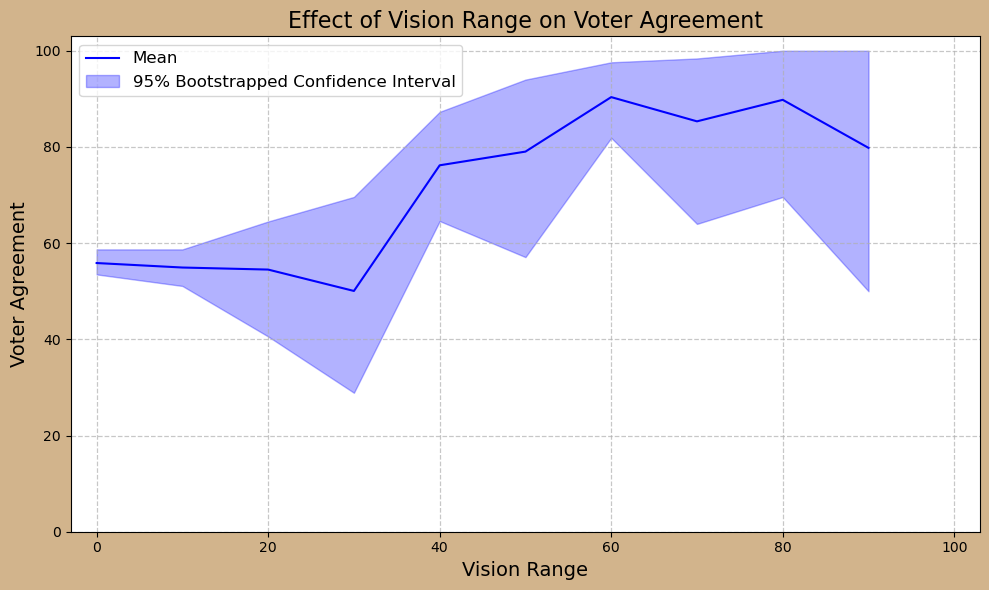

CPU times: total: 1.41 s
Wall time: 1.62 s


In [49]:
"""
Plot the results of 'bootstrap_ci' over the data generated above
"""

# Calculate the mean and IQR for each experiment (row)
means, lower_bound, upper_bound = bootstrap_ci(data, 1000, 95)

# Create a figure and set the background color
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#D2B48C')  # Brown contour

# Plot the mean values
ax.plot(range(0, 100, 100 // len(data[0])), means, label="Mean", color='blue')

# Plot the IQR-based confidence intervals
ax.fill_between(range(0, 100, 100 // len(data[0])), lower_bound, upper_bound, color='blue', alpha=0.3, label="95% Bootstrapped Confidence Interval")

# Set limits
ax.set_xlim(-3, 103)
ax.set_ylim(0.0, 103)

# Add grid for readability
ax.grid(True, which='both', linestyle='--', linewidth=0.9, alpha=0.7)

# Add labels and title
ax.set_xlabel("Vision Range", fontsize=14)
ax.set_ylabel("Voter Agreement", fontsize=14)
ax.set_title("Effect of Vision Range on Voter Agreement", fontsize=16)

# Add legend
ax.legend(fontsize=12, loc='upper left')

# Adjust plot margins for better spacing
plt.tight_layout()
plt.savefig('bootstrap_sincro.png', dpi=400)
plt.show()


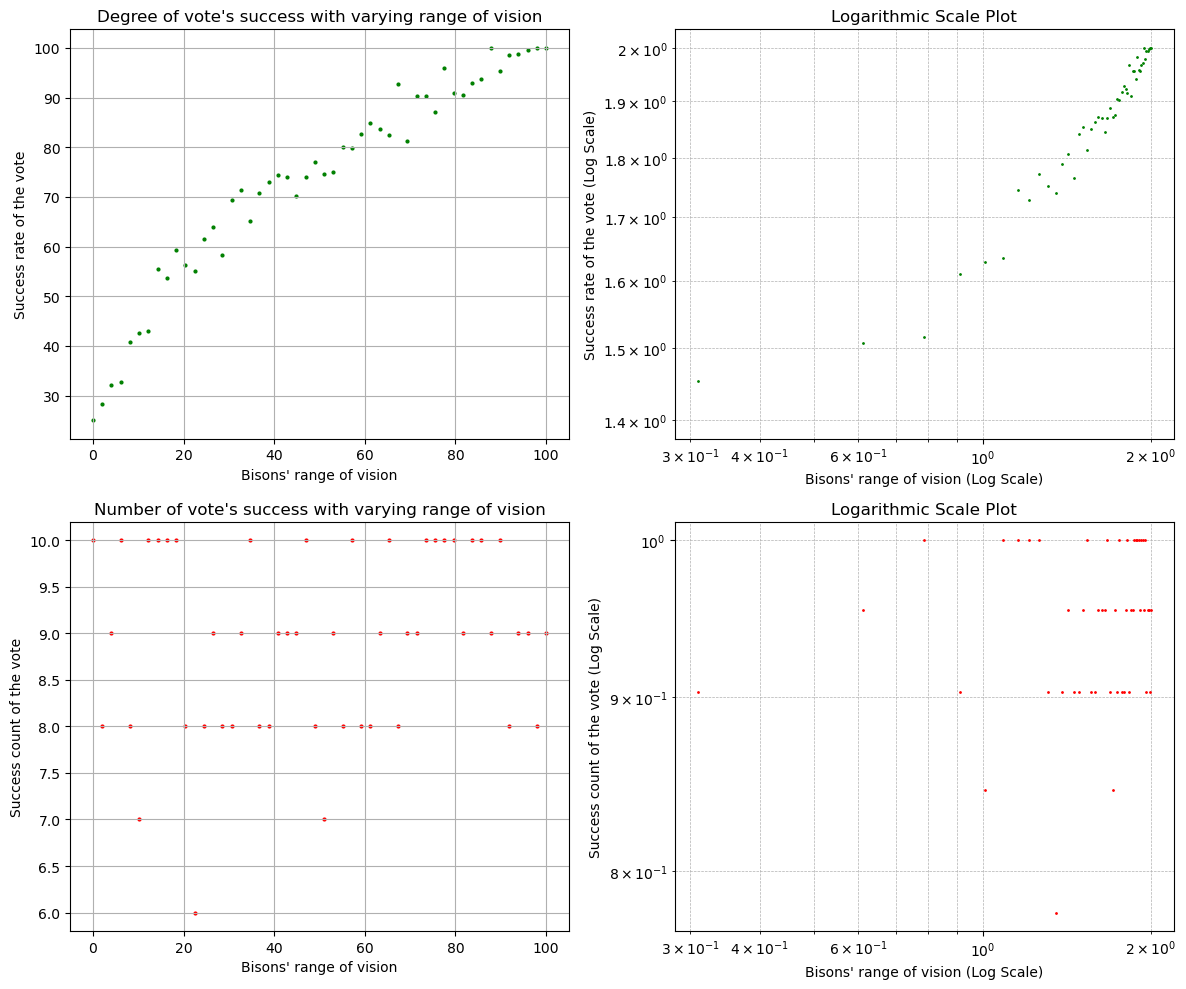

CPU times: total: 18.6 s
Wall time: 19.3 s


In [58]:
"""
Plots seperately both success rates and count over several runs of 'simulate_herd' function with varying vision_range
Both on linear and log-log scale
"""

# Initialisation of experiment
vision_range_par = np.linspace(0, 100, 50)
success_r = []
success_c = []
average_neighbours = []
abstention_rate = 55
voting_bias = 50

for i in vision_range_par:
    rate = []
    count = 0
    for _ in range(10):                                      
        herd, paired_bisons, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, success_rate, success_count, average_connection_size, decisions = simulate_herd(vision_range = i, herd_size=100, abstention_rate = abstention_rate, voting_bias = voting_bias)
        if success_rate != 0:
            rate.append(success_rate)
        count += success_count
    success_r.append(np.mean(rate))
    success_c.append(count)
    average_neighbours.append(average_connection_size)

# updated lists for log log plots
success_r_log = [math.log10(x) if x > 0 else 0 for x in success_r]
success_c_log = [math.log10(x) if x > 0 else 0 for x in success_c]
average_neighbours_log = [math.log10(x) if x > 0 else 0 for x in average_neighbours]
vision_range_par_log = [math.log10(x) if x > 0 else 0 for x in vision_range_par]

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# First subplot: success_rate vs vision_range (scatter plot)
axes[0][0].scatter(vision_range_par, success_r, s=4, color='green')
axes[0][0].set_xlabel("Bisons' range of vision")
axes[0][0].set_ylabel('Success rate of the vote')
axes[0][0].set_title("Degree of vote's success with varying range of vision")
axes[0][0].grid(True)

# Second subplot: success_rate vs vision_rang0e (log-log plot)
axes[0][1].loglog(vision_range_par_log, success_r_log, marker='o', linestyle='', color='green', markersize=1)
axes[0][1].set_xlabel("Bisons' range of vision (Log Scale)")
axes[0][1].set_ylabel("Success rate of the vote (Log Scale)")
axes[0][1].set_title("Logarithmic Scale Plot")
axes[0][1].grid(True, which="both", linestyle="--", linewidth=0.5)

# Third subplot: success_count vs vision_range (scatter plot)
axes[1][0].scatter(vision_range_par, success_c, s=4, color='red')
axes[1][0].set_xlabel("Bisons' range of vision")
axes[1][0].set_ylabel('Success count of the vote')
axes[1][0].set_title("Number of vote's success with varying range of vision")
axes[1][0].grid(True)

# Fourth subplot: success_count vs vision_range (log-log plot)
axes[1][1].loglog(vision_range_par_log, success_c_log, marker='o', linestyle='', color='red', markersize=1)
axes[1][1].set_xlabel("Bisons' range of vision (Log Scale)")
axes[1][1].set_ylabel("Success count of the vote (Log Scale)")
axes[1][1].set_title("Logarithmic Scale Plot")
axes[1][1].grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
#plt.savefig('success_vs_range_vision.png', dpi=300)
plt.show()

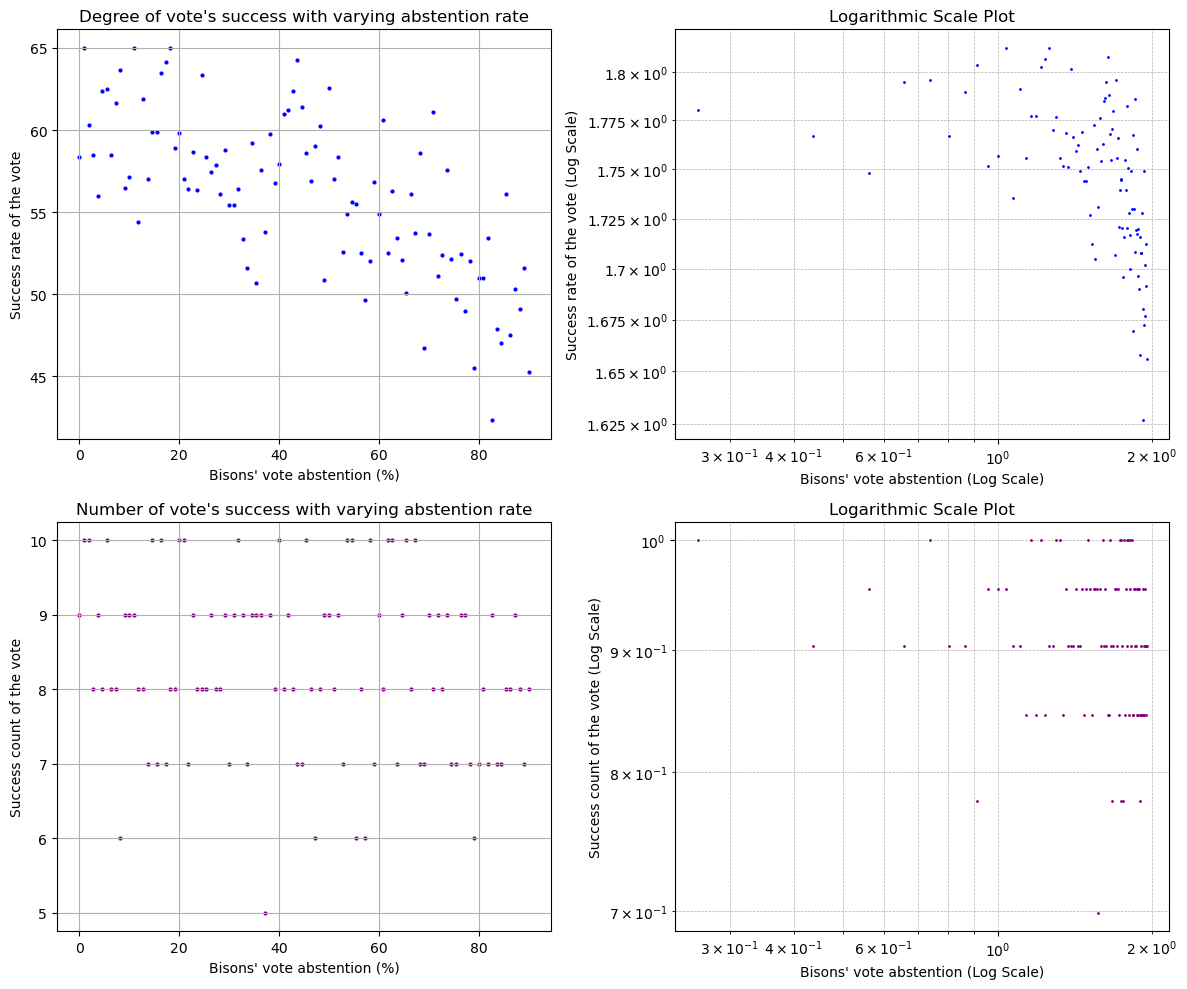

CPU times: total: 13.3 s
Wall time: 14.9 s


In [64]:
"""
Plots seperately both success rates and count over several runs of 'simulate_herd' function with varying abstention_rate
Both on linear and log-log scale
"""

# Initialisation of experiment
vision_range = 20
success_r = []
success_c = []
abstention_rate_par = np.linspace(0, 90, 100)
voting_bias = 50

for i in abstention_rate_par:
    rate = []
    count = 0
    for _ in range(10):                                      
        herd, paired_bisons, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, \
        success_rate, success_count, average_connection_size, decisions = simulate_herd(vision_range, \
        herd_size=100, abstention_rate = i, voting_bias = voting_bias)
        if success_rate != 0:
            rate.append(success_rate)
        count += success_count
    success_r.append(np.mean(rate))
    success_c.append(count)
    
# updated lists for log log plots
success_r_log = [math.log10(x) if x > 0 else 0 for x in success_r]
success_c_log = [math.log10(x) if x > 0 else 0 for x in success_c]
abstention_rate_par_log = [math.log10(x) if x > 0 else 0 for x in abstention_rate_par]

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# First subplot: success_rate vs vision_range (scatter plot)
axes[0][0].scatter(abstention_rate_par, success_r, s=4, color='blue')
axes[0][0].set_xlabel("Bisons' vote abstention (%)")
axes[0][0].set_ylabel('Success rate of the vote')
axes[0][0].set_title("Degree of vote's success with varying abstention rate")
axes[0][0].grid(True)

# Second subplot: success_rate vs vision_rang0e (log-log plot)
axes[0][1].loglog(abstention_rate_par_log, success_r_log, marker='o', linestyle='', color='blue', markersize=1)
axes[0][1].set_xlabel("Bisons' vote abstention (Log Scale)")
axes[0][1].set_ylabel("Success rate of the vote (Log Scale)")
axes[0][1].set_title("Logarithmic Scale Plot")
axes[0][1].grid(True, which="both", linestyle="--", linewidth=0.5)

# Third subplot: success_count vs vision_range (scatter plot)
axes[1][0].scatter(abstention_rate_par, success_c, s=4, color='purple')
axes[1][0].set_xlabel("Bisons' vote abstention (%)")
axes[1][0].set_ylabel('Success count of the vote')
axes[1][0].set_title("Number of vote's success with varying abstention rate")
axes[1][0].grid(True)

# Fourth subplot: success_count vs vision_range (log-log plot)
axes[1][1].loglog(abstention_rate_par_log, success_c_log, marker='o', linestyle='', color='purple', markersize=1)
axes[1][1].set_xlabel("Bisons' vote abstention (Log Scale)")
axes[1][1].set_ylabel("Success count of the vote (Log Scale)")
axes[1][1].set_title("Logarithmic Scale Plot")
axes[1][1].grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
#plt.savefig('success_vs_abstention.png', dpi=300)
plt.show()

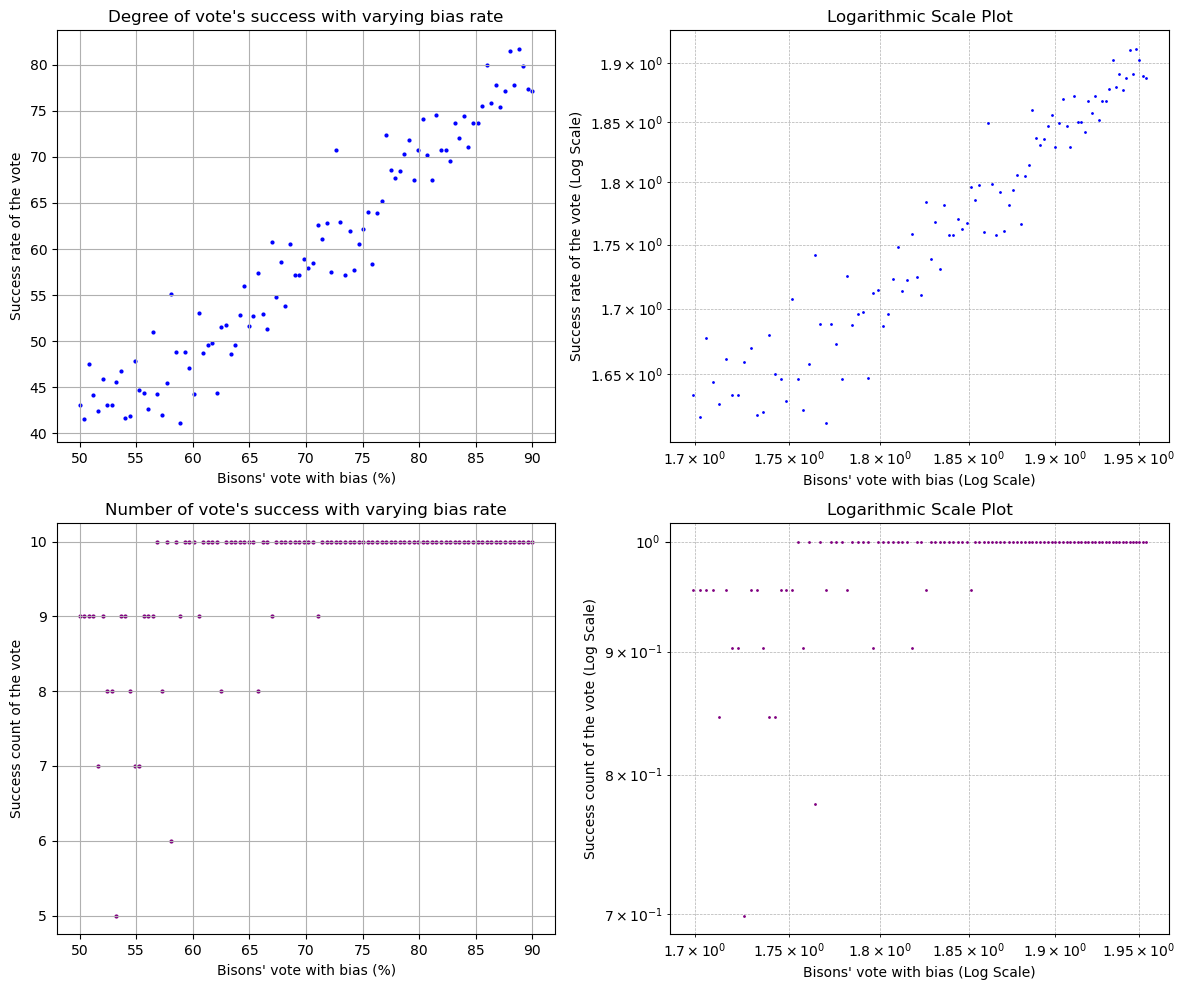

CPU times: total: 6.73 s
Wall time: 7.47 s


In [65]:
"""
Plots seperately both success rates and count over several runs of 'simulate_herd' function with varying voting_bias
Both on linear and log-log scale
"""

# Initialisation of experiment
vision_range = 10
success_r = []
success_c = []
abstention_rate = 55
voting_bias_par = np.linspace(50, 90, 100)

for i in voting_bias_par:
    rate = []
    count = 0
    for _ in range(10):                                      
        herd, paired_Bisons, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, \
        success_rate, success_count, average_connection_size, decisions = simulate_herd(vision_range, \
        herd_size=100, abstention_rate = abstention_rate, voting_bias = i)
        if success_rate != 0:
            rate.append(success_rate)
        count += success_count
    success_r.append(np.mean(rate))
    success_c.append(count)
    
# updated lists for log log plots
success_r_log = [math.log10(x) if x > 0 else 0 for x in success_r]
success_c_log = [math.log10(x) if x > 0 else 0 for x in success_c]
voting_bias_par_log = [math.log10(x) if x > 0 else 0 for x in voting_bias_par]

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# First subplot: success_rate vs vision_range (scatter plot)
axes[0][0].scatter(voting_bias_par, success_r, s=4, color='blue')
axes[0][0].set_xlabel("Bisons' vote with bias (%)")
axes[0][0].set_ylabel('Success rate of the vote')
axes[0][0].set_title("Degree of vote's success with varying bias rate")
axes[0][0].grid(True)

# Second subplot: success_rate vs vision_rang0e (log-log plot)
axes[0][1].loglog(voting_bias_par_log, success_r_log, marker='o', linestyle='', color='blue', markersize=1)
axes[0][1].set_xlabel("Bisons' vote with bias (Log Scale)")
axes[0][1].set_ylabel("Success rate of the vote (Log Scale)")
axes[0][1].set_title("Logarithmic Scale Plot")
axes[0][1].grid(True, which="both", linestyle="--", linewidth=0.5)

# Third subplot: success_count vs vision_range (scatter plot)
axes[1][0].scatter(voting_bias_par, success_c, s=4, color='purple')
axes[1][0].set_xlabel("Bisons' vote with bias (%)")
axes[1][0].set_ylabel('Success count of the vote')
axes[1][0].set_title("Number of vote's success with varying bias rate")
axes[1][0].grid(True)

# Fourth subplot: success_count vs vision_range (log-log plot)
axes[1][1].loglog(voting_bias_par_log, success_c_log, marker='o', linestyle='', color='purple', markersize=1)
axes[1][1].set_xlabel("Bisons' vote with bias (Log Scale)")
axes[1][1].set_ylabel("Success count of the vote (Log Scale)")
axes[1][1].set_title("Logarithmic Scale Plot")
axes[1][1].grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
#plt.savefig('success_vs_voting_bias.png', dpi=300)
plt.show()

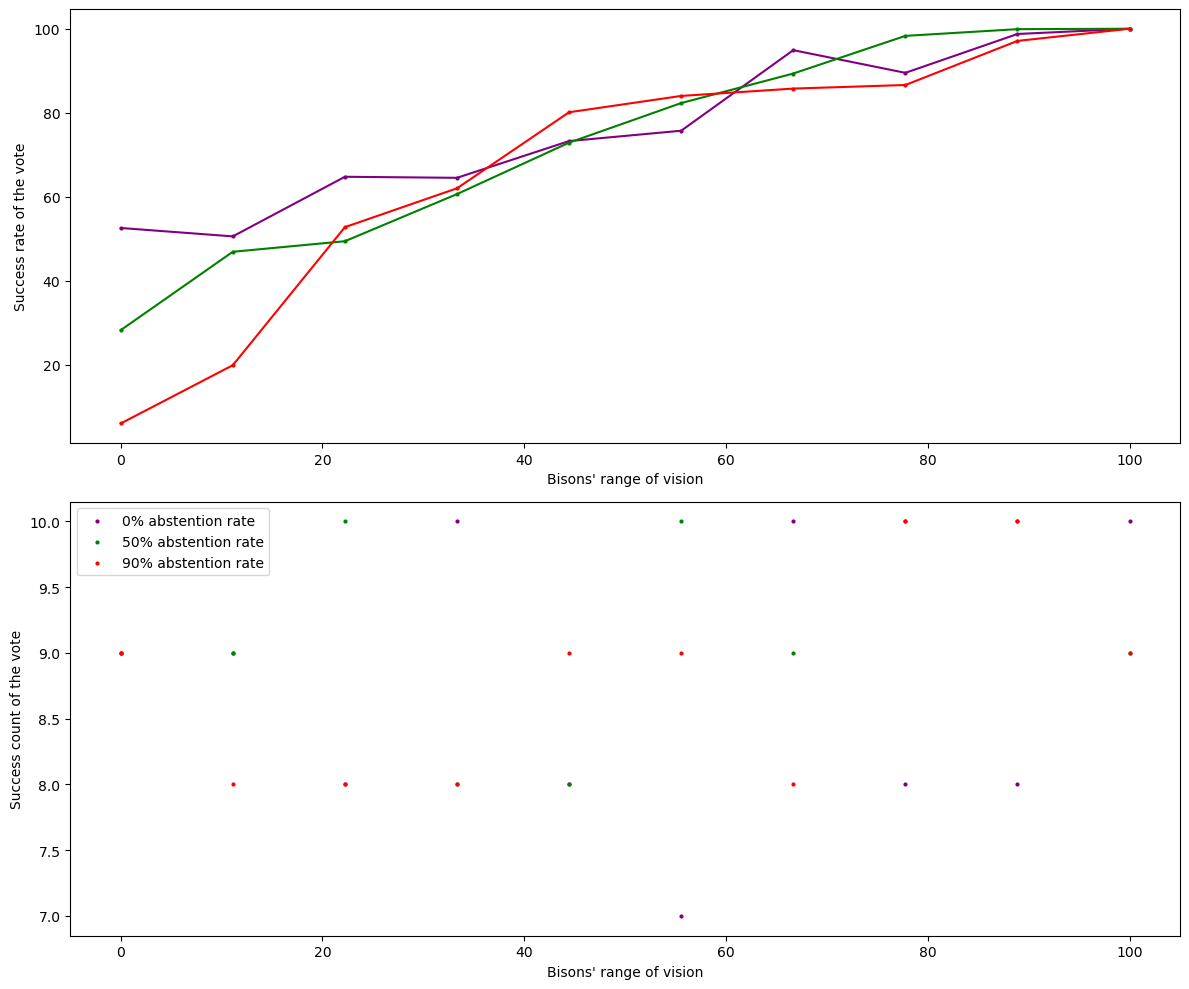

CPU times: total: 11.1 s
Wall time: 11.3 s


In [73]:
"""
Plots seperately both success rates and count over several runs of 'simulate_herd' function
with varying voting_bias for 3 distinct abstention_rate values (0, 50, 90)
"""

# Initialisation of experiment
vision_range = np.linspace(0, 100, 10)
success_r = [[],[],[]]
success_c = [[],[],[]]
abstention_rate = [0, 50, 90]
voting_bias_par = 50
coun = [0,1,2]

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

color_map = {0: 'purple', 1: 'green', 2: 'red'}

for j in coun:
    for i in vision_range:
        rate = []
        count = 0
        for _ in range(10):                                      
            herd, paired_bisons, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, \
            success_rate, success_count, average_connection_size, decisions = simulate_herd(vision_range = i, \
            herd_size=100, abstention_rate = abstention_rate[j], voting_bias = voting_bias_par)
            if success_rate != 0:
                rate.append(success_rate)
            count += success_count
        success_r[j].append(np.mean(rate))
        success_c[j].append(count)

    

    axes[0].scatter(vision_range, success_r[j], s=4, color=color_map[j])
    axes[0].plot(vision_range, success_r[j], linestyle='-', color=color_map[j], label= f'{abstention_rate[j]}% abstention rate')
    axes[0].set_xlabel("Bisons' range of vision")
    axes[0].set_ylabel('Success rate of the vote')


    axes[1].scatter(vision_range, success_c[j], s=4, color=color_map[j], label = f'{abstention_rate[j]}% abstention rate')
    axes[1].set_xlabel("Bisons' range of vision")
    axes[1].set_ylabel('Success count of the vote')

plt.legend()
plt.tight_layout()
plt.show()

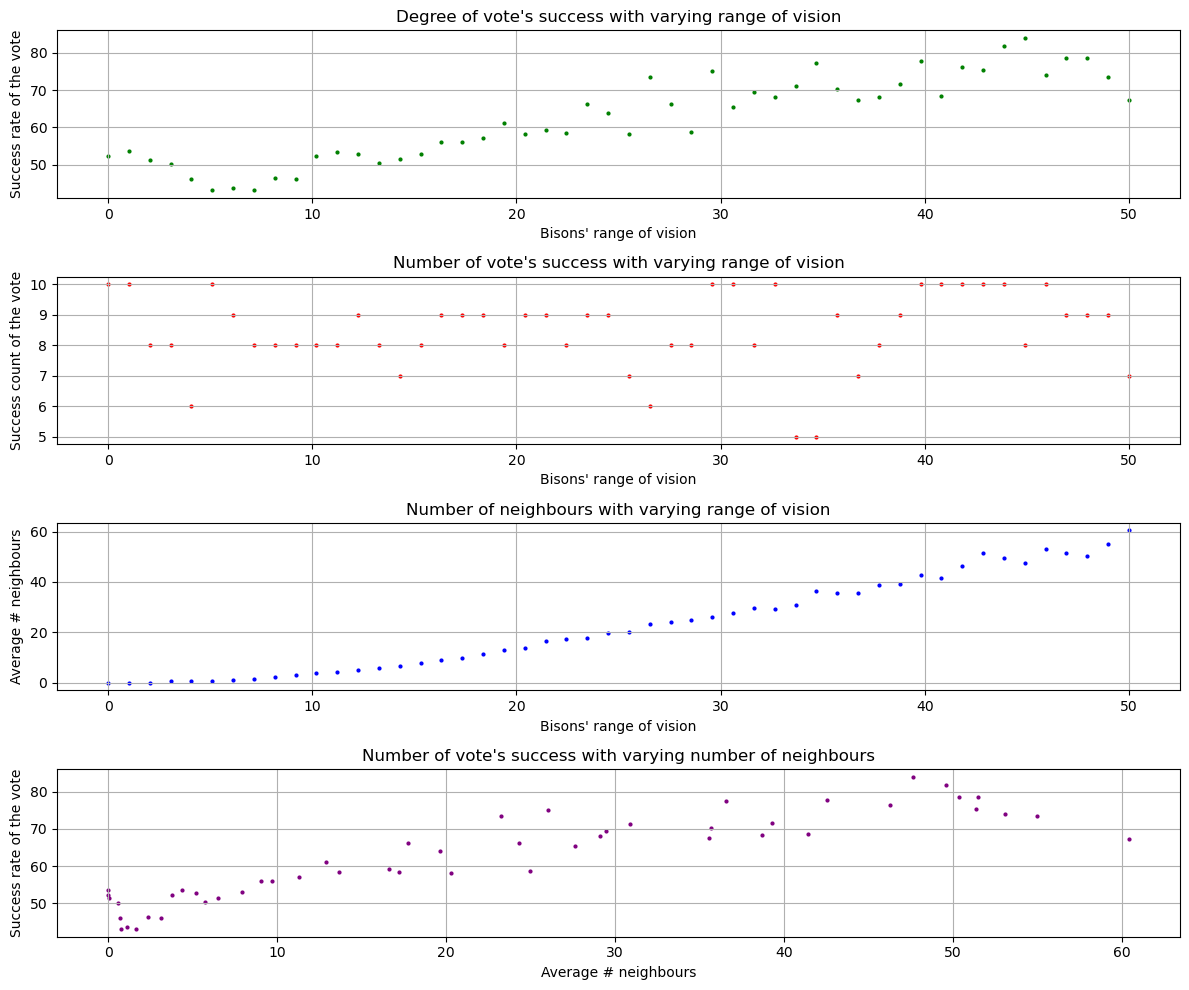

CPU times: total: 10.5 s
Wall time: 11.7 s


In [67]:
"""
Plots seperately average success rates, counts and average number of connected neighbours over several runs of 'simulate_herd' function with varying vision_range
+ plots how success rates vary with average number of connected neighbours
"""

# Initialisation of experiment
vision_range_par = np.linspace(0, 50, 50)
success_r = []
success_c = []
average_neighbours = []
abstention_rate = 0
voting_bias = 50

for i in vision_range_par:
    rate = []
    count = 0
    for _ in range(10):                                      
        herd, paired_bisons, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, success_rate, \
        success_count, average_connection_size, decisions = simulate_herd(vision_range = i, \
        herd_size=100, abstention_rate = abstention_rate, voting_bias = voting_bias)
        if success_rate != 0:
            rate.append(success_rate)
        count += success_count
    success_r.append(np.mean(rate))
    success_c.append(count)
    average_neighbours.append(average_connection_size)

# updated lists for log log plots

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# First subplot: success_rate vs vision_range (scatter plot)
axes[0].scatter(vision_range_par, success_r, s=4, color='green')
axes[0].set_xlabel("Bisons' range of vision")
axes[0].set_ylabel('Success rate of the vote')
axes[0].set_title("Degree of vote's success with varying range of vision")
axes[0].grid(True)


# Third subplot: success_count vs vision_range (scatter plot)
axes[1].scatter(vision_range_par, success_c, s=4, color='red')
axes[1].set_xlabel("Bisons' range of vision")
axes[1].set_ylabel('Success count of the vote')
axes[1].set_title("Number of vote's success with varying range of vision")
axes[1].grid(True)


# Fifth subplot: average neighbours vs vision_range (scatter plot)
axes[2].scatter(vision_range_par, average_neighbours, s=4, color='blue')
axes[2].set_xlabel("Bisons' range of vision")
axes[2].set_ylabel('Average # neighbours')
axes[2].set_title("Number of neighbours with varying range of vision")
axes[2].grid(True)

# Fifth subplot: average neighbours vs vision_range (scatter plot)
axes[3].scatter(average_neighbours, success_r, s=4, color='purple')
axes[3].set_xlabel("Average # neighbours")
axes[3].set_ylabel('Success rate of the vote')
axes[3].set_title("Number of vote's success with varying number of neighbours")
axes[3].grid(True)


plt.tight_layout()
#plt.savefig('success_vs_range_vision.png', dpi=300)
plt.show()

CPU times: total: 906 ms
Wall time: 949 ms


<function matplotlib.pyplot.show(close=None, block=None)>

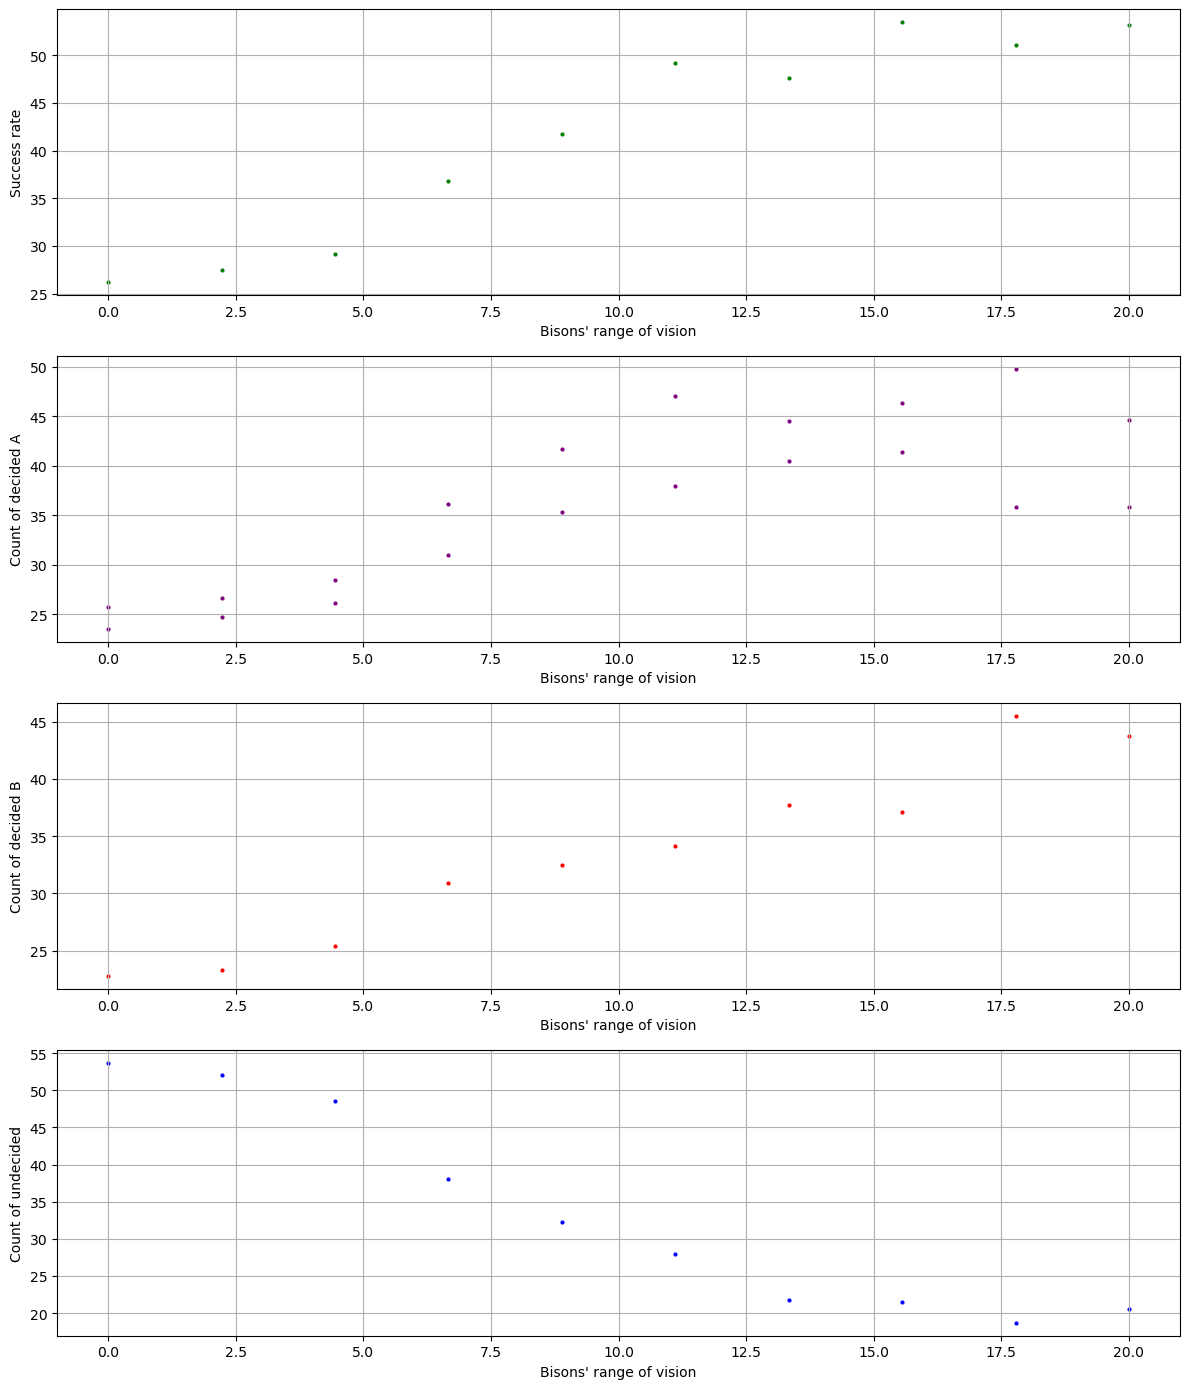

In [71]:
"""
Plots seperately average success rates and specific votes over several runs of 'simulate_herd' function with varying vision_range
"""

# Initialisation of experiment
vision_range_par = np.linspace(0, 20, 10)
undecisiveness = []
vote_xa = []
vote_xb = []
abstention_rate = 55
voting_bias = 50
success_r = []
winner = []

for i in vision_range_par:
    u_ = []
    a_ = []
    b_ = []
    w_ = []
    rate = []
    for _ in range(10):                                      
        herd, paired_bisons, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, success_rate, success_count, \
        average_connection_size, decisions = simulate_herd(vision_range = i, herd_size=100, \
        abstention_rate = abstention_rate, voting_bias = voting_bias)
        if len(vote_a) > len(vote_b):
            w = [x for x in decisions if x == 1]
        else:
            w = [x for x in decisions if x == -1]
            
        u = [x for x in decisions if x == 0]
        a = [x for x in decisions if x == 1]
        b = [x for x in decisions if x == -1]
        u_.append(len(u))
        a_.append(len(a))
        b_.append(len(b))
        w_.append(len(w))
        if success_rate != 0:
            rate.append(success_rate)
    success_r.append(np.mean(rate))
    undecisiveness.append(np.mean(u_))
    vote_xa.append(np.mean(a_))
    vote_xb.append(np.mean(b_))
    winner.append(np.mean(w_))
# updated lists for log log plots

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(4, 1, figsize=(12, 14))

# First subplot: success_rate vs vision_range (scatter plot)
axes[0].scatter(vision_range_par, success_r, s=4, color='green')
axes[0].set_xlabel("Bisons' range of vision")
axes[0].set_ylabel('Success rate')
axes[0].grid(True)


axes[1].scatter(vision_range_par, winner, s=4, color='purple')
axes[1].set_xlabel("Bisons' range of vision")
axes[1].set_ylabel('Count of success vote (A or B depending on vote)')
axes[1].grid(True)

axes[1].scatter(vision_range_par, vote_xa, s=4, color='purple')
axes[1].set_xlabel("Bisons' range of vision")
axes[1].set_ylabel('Count of decided A')
axes[1].grid(True)

# Third subplot: success_count vs vision_range (scatter plot)
axes[2].scatter(vision_range_par, vote_xb, s=4, color='red')
axes[2].set_xlabel("Bisons' range of vision")
axes[2].set_ylabel('Count of decided B')
axes[2].grid(True)


# Fifth subplot: average neighbours vs vision_range (scatter plot)
axes[3].scatter(vision_range_par, undecisiveness, s=4, color='blue')
axes[3].set_xlabel("Bisons' range of vision")
axes[3].set_ylabel('Count of undecided')
axes[3].grid(True)



plt.tight_layout()
plt.show

In [25]:
"""
This computes the minimum value of 'success_rate' with varying 'vision_range'
We saw that, with low abstention rate, the success rate of the vote dropped with low vision. 
This code was used to pull an estimation of the range of vision and number of average neighbours is required for the success rate to stagnate 
i.e. where the phase transition is between 'more vision and neighbours worsen the democratic process' and 'more vision and neighbours improves the democratic process'
"""
vision_range_r = np.linspace(0, 20, 50)
connectivity = []
success_r = []
abstention_rate = 0
voting_bias = 60

for i in vision_range_r:
    c = []
    s = []
    for _ in range(100):
        herd, paired_bisons, no_vote, vote_a, vote_b, cc_ratio, largest_cc_size, success_rate, success_count, average_connection_size, decisions = simulate_herd(vision_range = i,
            herd_size=100, abstention_rate = abstention_rate, voting_bias = voting_bias)
        c.append(average_connection_size)
        s.append(success_rate)
    connectivity.append(np.mean(c))
    success_r.append(np.mean(s))
min = np.argmin(success_r)

print(connectivity[min]) #estimated average node connection degree where the democratic process is neither worsen nor improved

print(vision_range_r[min]) #estimated vision range where the democratic process is neither worsen nor improved

1.244
5.714285714285714
CPU times: total: 28.1 s
Wall time: 31.7 s


In [ ]:
"""
Pull Success_rates over Z times X*Y runs with X (here 50) varying values for vision_range and Y (here 50) varying values for abstention_rate 
Values are the average of Z (here 30) runs
Plots these results in 3D with colormapping both continuous (surface) and discrete (scatter)

We also plot a low opacity plane for success_rate = 80 (desired rate of success)

In our presentation (appendix) we used much more runs : 100*100*100 which takes hours
"""
vision_range_par = np.linspace(100, 0, 50)
abstention_rate_par = np.linspace(99, 0, 50)
voting_bias_par = [50, 70]
X = np.linspace(0, 100, 2)  
x, y = np.meshgrid(X, X)
z = 80 

vision, abstention = np.meshgrid(vision_range_par, abstention_rate_par)

fig = plt.figure(figsize=(16, 16))

for idx, i in enumerate(voting_bias_par):
    success_rate = np.zeros_like(vision)

    for j in range(len(vision_range_par)):
        for k in range(len(abstention_rate_par)):
            v = vision_range_par[j]
            a = abstention_rate_par[k]

            success_rates = []

            for _ in range(30):  
                _, _, _, _, _, _, _, sr, _, _, _ = simulate_herd(
                    vision_range=v, herd_size=100, abstention_rate=a, voting_bias=i
                )
                if sr > 0:
                    success_rates.append(sr)

            success_rate[k, j] = np.mean(success_rates) if success_rates else 0  

    ax1 = fig.add_subplot(2, 2, 2 * idx + 1, projection="3d")
    
    cmap = "Spectral"
    
    scatter = ax1.scatter(vision, abstention, success_rate, c=success_rate, s=40, cmap=cmap)

    ax1.plot_surface(x, y, np.full_like(x, z), color='blue', alpha=0.2) 
    cbar1 = fig.colorbar(scatter, shrink=0.5, aspect=5, ax=ax1)
    cbar1.set_label("Success Rate (0-100)")

    ax1.set_xlabel("Bison Vision Range")
    ax1.set_ylabel("Herd Abstention Rate")
    ax1.set_zlabel("Success Rate")
    ax1.set_xlim(100, 0)
    ax1.set_ylim(100, 0)
    ax1.set_title(f"Voting Bias = {i} (Scatter)")

    ax2 = fig.add_subplot(2, 2, 2 * idx + 2, projection="3d")
    
    surf = ax2.plot_surface(vision, abstention, success_rate, cmap=cmap, edgecolor='none')

    ax2.plot_surface(x, y, np.full_like(x, z), color='blue', alpha=0.2) 
    cbar2 = fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax2)
    cbar2.set_label("Success Rate (0-100)")

    ax2.set_xlabel("Bison Vision Range")
    ax2.set_ylabel("Herd Abstention Rate")
    ax2.set_zlabel("Success Rate")
    ax2.set_xlim(100, 0)
    ax2.set_ylim(100, 0)
    ax2.set_title(f"Voting Bias = {i} (Surface)")

plt.suptitle("Success Rate of Voting Model", fontsize=16)
#plt.savefig('Success_Rate_Voting_Model.png', dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
"""
plot different success rates from the same runs as above for a limited amount of abstention_rate values with varying vision_range values
"""


fixed_abstention_values = [abstention_rate_par[17], abstention_rate_par[21], abstention_rate_par[25], \
                       abstention_rate_par[29], abstention_rate_par[33], abstention_rate_par[37], \
                       abstention_rate_par[41], abstention_rate_par[45], abstention_rate_par[49]] 

plt.figure(figsize=(10, 5))
fig = plt.gcf() 
fig.patch.set_facecolor('#D2B48C')
for j in fixed_abstention_values:
    
    fixed_index = np.argmin(np.abs(abstention_rate_par - j))
    success_rate_fixed_abstention = success_rate[fixed_index, :]
    plt.plot(vision_range_par, success_rate_fixed_abstention, label=f"Abstention Rate = {j:.0f}")
    
plt.xlabel("Bison Vision Range")
plt.ylabel("Voter Agreement")
plt.title("Voter Agreement for Voting Bias = 50, with varying Vision Range")
plt.legend()
plt.grid(True)
plt.savefig('success_vs_vision.png', dpi=300)
plt.show()

In [ ]:
"""
plot different success rates from the same runs as above for a limited amount of vision_range values with varying abstention_rate values
"""

fixed_vision_values = [vision_range_par[17], vision_range_par[21], vision_range_par[25], \
                       vision_range_par[29], vision_range_par[33], vision_range_par[37], \
                       vision_range_par[41], vision_range_par[45], vision_range_par[49]] 

plt.figure(figsize=(10, 5))
fig = plt.gcf()
fig.patch.set_facecolor('#D2B48C')

for j in fixed_vision_values:
    fixed_index = np.argmin(np.abs(vision_range_par - j))
    
    success_rate_fixed_vision = success_rate[:, fixed_index]
    
    plt.plot(abstention_rate_par[::-1], success_rate_fixed_vision, label=f"Vision Range = {j:.0f}")
    
plt.xlabel("Bison Abstention Rate")
plt.ylabel("Voter Agreement")
plt.title("Voter Agreement for Voting Bias = 50, with Varying Abstention Rate")
plt.legend()
plt.grid(True)
plt.savefig('success_vs_abstention.png', dpi=300)
plt.show()

In [ ]:
"""
Pull Success_counts over Z times X*Y runs with X (here 50) varying values for vision_range and Y (here 50) varying values for abstention_rate 
Values are the average of Z (here 30) runs
Plots these results in 3D with colormapping both continuous (surface) and discrete (scatter)

We also plot a low opacity plane for success_count = 80 (desired rate of success, supported by research data)

In our presentation (appendix) we used much more runs : 100*100*100 which takes hours
"""
vision_range_par = np.linspace(100, 0, 50)
abstention_rate_par = np.linspace(99, 0, 50)
voting_bias_par = [50, 70]
X = np.linspace(0, 100, 2)  
x, y = np.meshgrid(X, X)
z = 80 

vision, abstention = np.meshgrid(vision_range_par, abstention_rate_par)

fig = plt.figure(figsize=(16, 16))


for idx, i in enumerate(voting_bias_par):
    success_count = np.zeros_like(vision)

    for j in range(len(vision_range_par)):
        for k in range(len(abstention_rate_par)):
            v = vision_range_par[j]
            a = abstention_rate_par[k]

            success_counts = []

            for _ in range(30):  
                _, _, _, _, _, _, _, _, sr, _, _ = simulate_herd(
                    vision_range=v, herd_size=100, abstention_rate=a, voting_bias=i
                )
                success_counts.append(sr)

            success_count[k, j] = np.mean(success_counts) * 100

    ax1 = fig.add_subplot(2, 2, 2 * idx + 1, projection="3d")
    ax1.set_facecolor('#D2B48C')
    
    cmap = "Spectral"
    
    scatter = ax1.scatter(vision, abstention, success_count, c=success_count, s=40, cmap=cmap)

    ax1.plot_surface(x, y, np.full_like(x, z), color='blue', alpha=0.2) 
    cbar1 = fig.colorbar(scatter, shrink=0.5, aspect=5, ax=ax1)
    cbar1.set_label("Democratic Success Count (0-100)")

    ax1.set_xlabel("Bison Vision Range")
    ax1.set_ylabel("Herd Abstention Rate")
    ax1.set_zlabel("Democratic Success Count out of 30 runs")
    ax1.set_xlim(100, 0)
    ax1.set_ylim(100, 0)
    ax1.set_title(f"Voting Bias = {i} (Scatter)")

    ax2 = fig.add_subplot(2, 2, 2 * idx + 2, projection="3d")
    ax2.set_facecolor('#D2B48C')
    
    surf = ax2.plot_surface(vision, abstention, success_count, cmap=cmap, edgecolor='none')

    ax2.plot_surface(x, y, np.full_like(x, z), color='blue', alpha=0.2) 
    cbar2 = fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax2)
    cbar2.set_label("Democratic Success Count (0-100)")

    ax2.set_xlabel("Bison Vision Range")
    ax2.set_ylabel("Herd Abstention Rate")
    ax2.set_zlabel("Democratic Success Count out of 30 runs")
    ax2.set_xlim(100, 0)
    ax2.set_ylim(100, 0)
    ax2.set_title(f"Voting Bias = {i} (Surface)")

plt.suptitle("Democratic Success Count of Voting Model", fontsize=16)
plt.savefig('Success_Count_Voting_Model.png', dpi=300)
plt.tight_layout()
plt.show()